In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import optax

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
from tqdm import trange

from laplax import ADLaplace
from utils import train_model
import distrax

In [2]:
def get_likelihood(params, aux):
    loc = params['w1'] * aux['x'][0] + params['w2'] * aux['x'][1]
    scale = 1.0
    return distrax.Normal(loc, scale)

def prepare_model(config_name, bijector):
    config = pd.read_pickle(f'../data/{config_name}')
    data = config['data']
    aux = {'x': data['x']}
    y = data['y']
    prior_loc = config['prior']['mean']
    prior_scale = jnp.diag(config['prior']['var'])**0.5
    
    prior = {'w1': tfd.Normal(loc=prior_loc[0], scale=prior_scale[0]), 
            "w2": tfd.Normal(loc=prior_loc[1], scale=prior_scale[1])}
    bijectors = {'w1': bijector, "w2": bijector}
    
    return ADLaplace(prior, bijectors, get_likelihood), y, aux

In [3]:
model, data, aux = prepare_model(config_name='linear_regression', bijector=tfb.Identity())

optimizer = optax.adam(learning_rate=1.0)
n_epochs = 100
seed = jax.random.PRNGKey(0)

params, losses = train_model(model, data, aux, optimizer, n_epochs, seed)

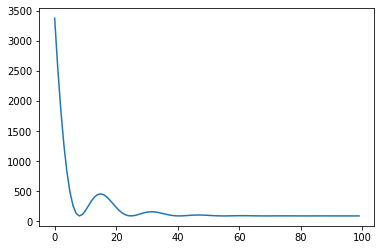

In [4]:
plt.plot(losses);

In [5]:
posterior = model.apply(params, data, aux)

In [6]:
posterior.log_prob({'w1': jnp.array([0.1, 0.2]), "w2": jnp.array([0.1, 0.2])})

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())